In [65]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from datetime import timedelta, datetime
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from typhon.plots import worldmap, styles, get_cfeatures_at_scale, profile_p
from typhon.files import FileSet
from typhon.collocations import Collocator
from typhon.physics import vmr2relative_humidity, mixing_ratio2vmr
plt.style.use(styles.get('typhon'))

In [97]:
iasi_fs = FileSet(path="/scratch/uni/u237/user_data/mprange/iasi_eumetsat_retrieval_data/1378562-2of3/"
                  "*"
                  "{year}{month}{day}{hour}{minute}{second}_*_eps_o_l2.nc")
data_list = iasi_fs.collect("2020-02-01", "2020-02-02")

In [101]:
def find_nearest(array, value):
    array = np.asarray(array)
    return (np.abs(array - value)).argmin()

def plot_wv_map(data_list, plevel):
    fig = plt.figure(figsize=(16,10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    for data in data_list:
        p_ind = find_nearest(data['pressure_levels_humidity'], plevel * 100.)
        wv = get_domain_array(data, 'atmospheric_water_vapor')
        wv_vmr = mixing_ratio2vmr(wv)
        T = get_domain_array(data, 'atmospheric_temperature')
        P = data['pressure_levels_humidity'].values
        RH = vmr2relative_humidity(wv_vmr, P, T) * 100.
        scat = worldmap(
            data["lat"], data["lon"], RH[:,:,p_ind], 
            draw_coastlines=True, cmap='density', ax=ax, draw_grid=True, 
#             vmin=2.0e-6, vmax=4.0e-6,
                       )
        s = f"{np.round(data['pressure_levels_humidity'][p_ind].values / 100., 0)}"
        plt.title(f"p = {s} hPa", y=1.1)
    plt.colorbar(scat, fraction=0.015, label='Relative Humidity [%]')
    ax.set_extent([-100, 0, 0, 30], crs=ccrs.PlateCarree())
    
    
def plot_temp_map(data_list, plevel):
    fig = plt.figure(figsize=(16,10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    for data in data_list:
        p_ind = find_nearest(data['pressure_levels_humidity'], plevel * 100.)
        T = get_domain_array(data, 'atmospheric_temperature')
        scat = worldmap(
            data["lat"], data["lon"], T[:,:,p_ind], 
            draw_coastlines=True, cmap='temperature', ax=ax, draw_grid=True, 
#             vmin=2.0e-6, vmax=4.0e-6,
                       )
        s = f"{np.round(data['pressure_levels_humidity'][p_ind].values / 100., 0)}"
        plt.title(f"p = {s} hPa", y=1.1)
    plt.colorbar(scat, fraction=0.015, label='Temperature [K]')
    ax.set_extent([-100, 0, 0, 30], crs=ccrs.PlateCarree())
    
    
def get_domain_array(data, var_name):
    return data[var_name].where(
        (data.lat > 6.) & (data.lat < 24.) & 
        (data.lon > -90.) & (data.lon < -10.)).values


def get_iasi_collocations(iasi_data, collocation_latitudes, 
                          collocation_longitudes, collocation_radius, 
                          profiles_available=False):
    sy = iasi_data.start_sensing_data_time[:4]
    sm = iasi_data.start_sensing_data_time[4:6]
    sd = iasi_data.start_sensing_data_time[6:8]
    sH = iasi_data.start_sensing_data_time[8:10]
    sM = iasi_data.start_sensing_data_time[10:12]
    sS = iasi_data.start_sensing_data_time[12:14]
    start_date = f"{sy}-{sm}-{sd} {sH}:{sM}:{sS}"
    ey = iasi_data.end_sensing_data_time[:4]
    em = iasi_data.end_sensing_data_time[4:6]
    ed = iasi_data.end_sensing_data_time[6:8]
    eH = iasi_data.end_sensing_data_time[8:10]
    eM = iasi_data.end_sensing_data_time[10:12]
    eS = iasi_data.end_sensing_data_time[12:14]
    end_date = f"{ey}-{em}-{ed} {eH}:{eM}:{eS}"

    iasi_collocation_ds = xr.Dataset(
    {
        'lat': iasi_data.lat,
        'lon': iasi_data.lon,
        'time': (('along_track'), 
                     np.arange(np.datetime64(start_date), 
                               np.datetime64(end_date), 
                               np.timedelta64(8, 's'), 
                               dtype='datetime64'))
    })
    print("Constraining iasi_data to general EUREC4A region before collocating...")
    iasi_data = iasi_data.where(
        (iasi_data.lat > 6.) & (iasi_data.lat < 18.) & 
        (iasi_data.lon > -90.) & (iasi_data.lon < -45.)
    ) 
    iasi_collocation_ds = xr.Dataset(
    {
        'lat': iasi_data.lat,
        'lon': iasi_data.lon,
        'time': (('along_track'), 
                     np.arange(np.datetime64(start_date), 
                               np.datetime64(end_date), 
                               np.timedelta64(8, 's'), 
                               dtype='datetime64')),
        'atmospheric_water_vapor': iasi_data.atmospheric_water_vapor,
        'atmospheric_temperature': iasi_data.atmospheric_temperature,
        
    })
    eurec4a_loc_ds = xr.Dataset(
        {
            'lat': collocation_latitudes,
            'lon': collocation_longitudes,
            'time': np.array([f'{sy}-{sm}-{sd}'], dtype="datetime64")
        }
    )
    collocater = Collocator(threads=4, name='eurec4a_loc_iasi')
    print("Collocating...")
    collocations = collocater.collocate(
        primary=('eurec4a_locations', eurec4a_loc_ds), 
        secondary=('iasi', iasi_collocation_ds),
        max_distance=collocation_radius, 
        max_interval=timedelta(days=1)
    )
    if profiles_available:
        collocations = collocations.isel({
            'Collocations/collocation': ~np.isnan(collocations['iasi/atmospheric_water_vapor'][0,:]).values, 
            'iasi/collocation': ~np.isnan(collocations['iasi/atmospheric_water_vapor'][0,:]).values,
        }
        )
    return collocations
    
    
def plot_collocated_profiles(collocations, fig=None, axs=None, alpha=1.0):
    n_profiles = len(collocations['Collocations/collocation'])
    if not (fig and axs):
        fig, axs = plt.subplots(ncols=3, sharey=True)
    for i in range(n_profiles):
        P = collocations['iasi/pressure_levels_humidity'].values
        T = collocations['iasi/atmospheric_temperature'][:, i].values
        wv_vmr = mixing_ratio2vmr(collocations['iasi/atmospheric_water_vapor'][:, i].values)
        RH = vmr2relative_humidity(wv_vmr, P, T) * 100.
        profile_p(P, T, ax=axs[0], alpha=alpha)
        profile_p(P, RH, ax=axs[1], alpha=alpha)
        profile_p(P, wv_vmr, ax=axs[2], alpha=alpha,
                 label=f"{np.array(collocations['iasi/time'][i].values, dtype='datetime64[s]')}")
        axs[0].set_xlabel('Temperature [K]')
        axs[1].set_xlabel('Relative Humidity [%]')
        axs[2].set_xlabel('H${_2}$O VMR [-]')
    axs[2].legend(bbox_to_anchor=(1.1, 1))
    return fig, axs
    
def plot_radiosonde_profiles(radiosonde_data, fig=None, axs=None):
    if not fig and not axs:
        fig, axs = plt.subplots(ncols=3, sharey=True, figsize=(20, 10))
    P = radiosonde_data['pressure'][0].values * 100.
    T = radiosonde_data['temperature'][0].values + 273.15
    wv_vmr = mixing_ratio2vmr(radiosonde_data['mixingRatio'][0].values / 1000.)
    RH = radiosonde_data['humidity'][0].values
    profile_p(P, T, ax=axs[0], color='black')
    profile_p(P, RH, ax=axs[1], color='black')
    profile_p(P, wv_vmr, ax=axs[2], color='black', 
             label=f"{np.array(radiosonde_data['flight_time'][0, 0].values, dtype='datetime64[s]')}")
    axs[0].set_xlabel('Temperature [K]')
    axs[1].set_xlabel('Relative Humidity [%]')
    axs[2].set_xlabel('H${_2}$O VMR [-]')
    axs[2].legend(bbox_to_anchor=(1.1, 1))
    return fig, axs

In [61]:
radiosonde_data['pressure'][0].values

array([1014.72, 1014.16, 1013.58, ...,   54.47,   54.44,   50.  ],
      dtype=float32)

In [48]:
rs_data = xr.open_dataset('/scratch/uni/u237/user_data/mprange/Auswahl_ClearSkySondes/'
                'BCO_SoundingAscentProfile_DeeblesPointBarbadosWestIndies_20200201_1048.nc')
rs_data

<xarray.Dataset>
Dimensions:        (levels: 4174, sounding: 1)
Coordinates:
  * sounding       (sounding) object b'BCO__13.16_-59.43__202002011048'
    flight_time    (sounding, levels) datetime64[ns] ...
    pressure       (sounding, levels) float32 ...
    latitude       (sounding, levels) float32 ...
    longitude      (sounding, levels) float32 ...
Dimensions without coordinates: levels
Data variables:
    launch_time    (sounding) datetime64[ns] ...
    ascentRate     (sounding, levels) float32 ...
    altitude       (sounding, levels) float32 ...
    temperature    (sounding, levels) float32 ...
    humidity       (sounding, levels) float32 ...
    dewPoint       (sounding, levels) float32 ...
    mixingRatio    (sounding, levels) float32 ...
    windSpeed      (sounding, levels) float32 ...
    windDirection  (sounding, levels) float32 ...
Attributes:
    title:                         Sounding data containing temperature, pres...
    platform_name:                 Barbados Cloud Observatory (BCO)
    location:                      Deebles Point, Barbados, West Indies
    surface_altitude:              25 m
    instrument:                    Radiosonde RS41 by Vaisala
    number_of_Probe:               R4540909
    sonde_type:                    123
    sonde_frequency:               400200000.0Hz
    date_YYYYMMDD:                 20200201
    time_of_launch_HHmmss:         104850
    launch_unixtime:               1580554130.0
    latitude_of_launch_location:   13.16 deg N
    longitude_of_launch_location:  -59.43 deg E
    resolution:                    1 sec
    source:                        C:/Messages/IUSN74_309057_20200201_104850_...
    git_version:                   --
    created_with:                  L1_bufr.py with its last modifications on ...
    created_on:                    Sat Feb  1 18:02:25 2020
    contact_person:                Hauke Schulz (hauke.schulz@mpimet.mpg.de)
    institution:                   Max Planck Institute for Meteorology
    converted_by:                  BCO ground crew (n/a)
    python_version:                3.7.6 | packaged by conda-forge | (default...
    Conventions:                   CF-1.7
    featureType:                   trajectory

In [86]:
collocations = get_iasi_collocations(
    data_list[0], np.array([13.15]), np.array([-59.42]), 300., 
    profiles_available=True)
collocations

Constraining iasi_data to general EUREC4A region before collocating...
Collocating...


<xarray.Dataset>
Dimensions:                        (Collocations/collocation: 3, Collocations/group: 2, eurec4a_locations/collocation: 1, eurec4a_locations/lat: 1, eurec4a_locations/lon: 1, iasi/collocation: 3, iasi/nlq: 101, iasi/nlt: 101)
Coordinates:
  * eurec4a_locations/lat          (eurec4a_locations/lat) float64 13.15
  * eurec4a_locations/lon          (eurec4a_locations/lon) float64 -59.42
    iasi/lon                       (iasi/collocation) float64 -57.56 ... -57.01
    iasi/lat                       (iasi/collocation) float64 11.57 13.89 14.36
    iasi/pressure_levels_humidity  (iasi/nlq) float64 ...
    iasi/pressure_levels_temp      (iasi/nlt) float64 ...
  * Collocations/group             (Collocations/group) <U17 'eurec4a_locations' 'iasi'
Dimensions without coordinates: Collocations/collocation, eurec4a_locations/collocation, iasi/collocation, iasi/nlq, iasi/nlt
Data variables:
    eurec4a_locations/time         (eurec4a_locations/collocation) datetime64[ns] 2020-02-01
    iasi/time                      (iasi/collocation) datetime64[ns] 2020-02-01T12:48:50 ... 2020-02-01T12:48:02
    iasi/atmospheric_water_vapor   (iasi/nlq, iasi/collocation) float64 1.8e-06 ... nan
    iasi/atmospheric_temperature   (iasi/nlt, iasi/collocation) float32 192.26 ... nan
    iasi/along_track               (iasi/collocation) int64 119 114 113
    iasi/across_track              (iasi/collocation) int64 117 117 117
    Collocations/pairs             (Collocations/group, Collocations/collocation) int64 0 ... 21
    Collocations/interval          (Collocations/collocation) timedelta64[ns] 12:48:50 ... 12:48:02
    Collocations/distance          (Collocations/collocation) float64 268.4 ... 293.0
Attributes:
    start_time:  2020-02-01 00:00:00
    end_time:    2020-02-01 00:00:00

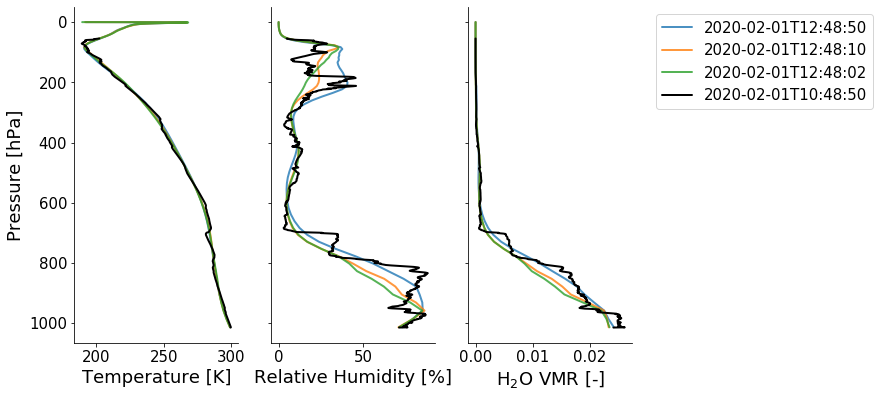

In [90]:
fig, axs = plot_collocated_profiles(collocations, alpha=0.8)
plot_radiosonde_profiles(radiosonde_data, fig=fig, axs=axs)
plt.savefig('plots/bco_radiosonde_iasi+retrieval_first_comparison.pdf')

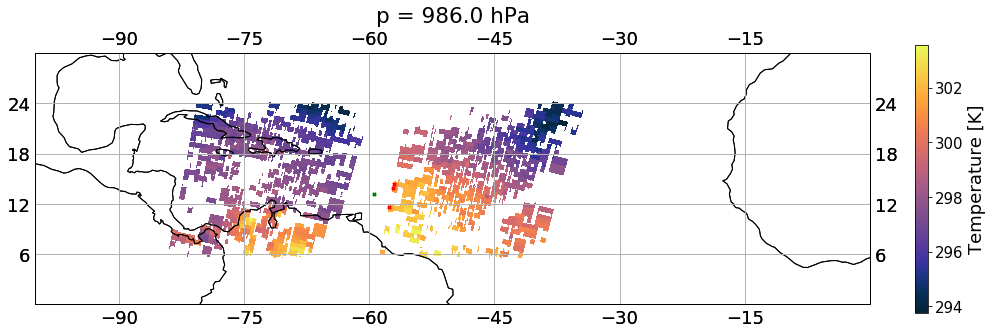

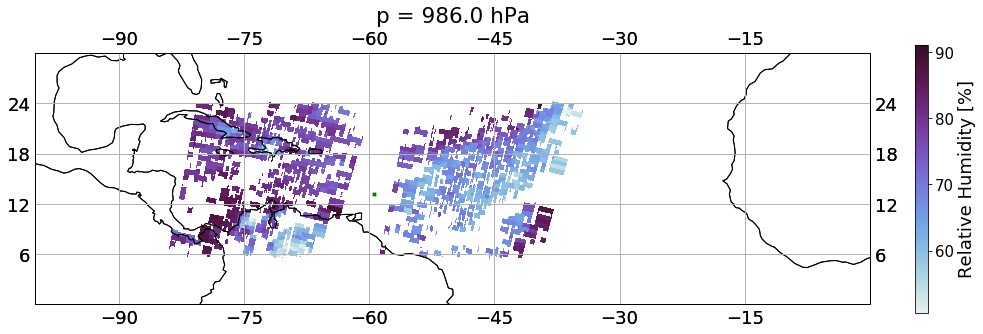

In [102]:
plot_temp_map(data_list, 1000.)
worldmap(collocations['iasi/lat'], collocations['iasi/lon'], 
         marker='x', color='red', s=10)
worldmap(collocations['eurec4a_locations/lat'], collocations['eurec4a_locations/lon'], 
         marker='x', color='green', s=10)
plt.savefig('plots/temp_map_2020_02_01.pdf')
plot_wv_map(data_list, 1000.)
worldmap(collocations['eurec4a_locations/lat'], collocations['eurec4a_locations/lon'], 
         marker='x', color='green', s=10)
plt.savefig('plots/rh_map_2020_02_01.pdf')